In [1]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models
import kagglehub
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Downloading dataset from Kaggle
path = kagglehub.dataset_download("ekaakurniawan/the-cifar10-dataset")
print(path)

/root/.cache/kagglehub/datasets/ekaakurniawan/the-cifar10-dataset/versions/1


In [3]:
# Print the contents of the downloaded dataset directory to inspect its structure
print("Contents of dataset directory:", os.listdir(path))

Contents of dataset directory: ['cifar-10-batches-py']


In [4]:
# Function to load CIFAR-10 dataset
def load_cifar10_dataset(path):
    def unpickle(file):
        with open(file, 'rb') as fo:
            data = pickle.load(fo, encoding='bytes')
        return data

    train_data, train_labels = [], []
    for i in range(1, 6):
        batch = unpickle(os.path.join(path, 'cifar-10-batches-py', f"data_batch_{i}"))
        train_data.append(batch[b'data'])
        train_labels += batch[b'labels']
    train_data = np.vstack(train_data).reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)

    test_batch = unpickle(os.path.join(path, 'cifar-10-batches-py', "test_batch"))
    test_data = test_batch[b'data'].reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)
    test_labels = test_batch[b'labels']

    return (train_data, np.array(train_labels)), (test_data, np.array(test_labels))

In [5]:
# Load dataset
(train_images, train_labels), (test_images, test_labels) = load_cifar10_dataset(path)

In [6]:
# Normalize images to [0, 1]
train_images = train_images / 255.0
test_images = test_images / 255.0

In [7]:
train_images.shape

(50000, 32, 32, 3)

In [8]:
test_images.shape

(10000, 32, 32, 3)

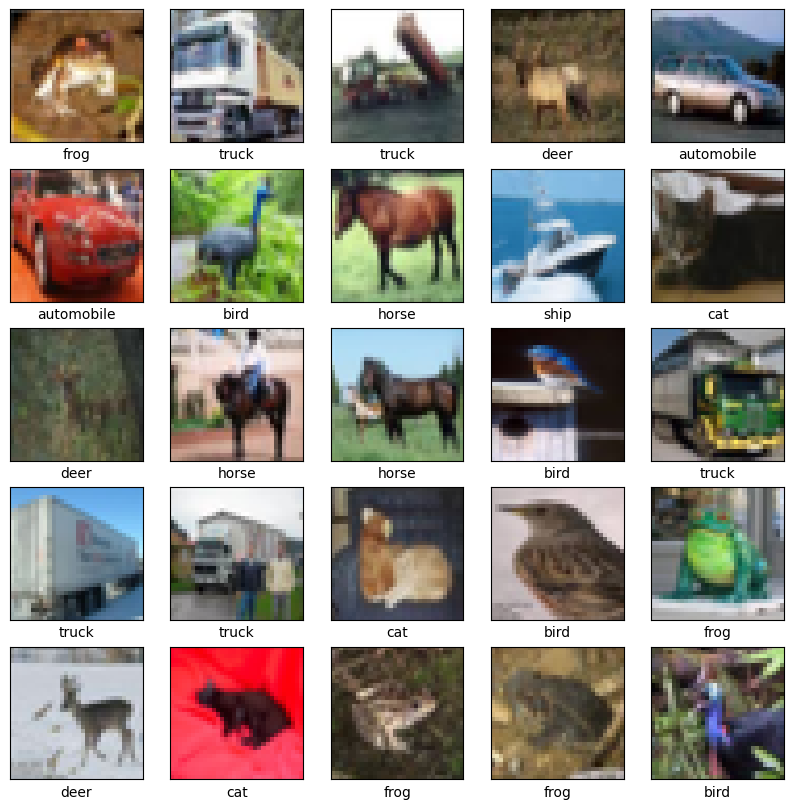

In [9]:
import seaborn as sns
# Class names for CIFAR-10 dataset
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Display some sample images from the training dataset
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i])
    plt.xlabel(class_names[train_labels[i]])
plt.show()

Mean Pixel Values: [0.49139968 0.48215841 0.44653091]
Standard Deviation of Pixel Values: [0.24703223 0.24348513 0.26158784]


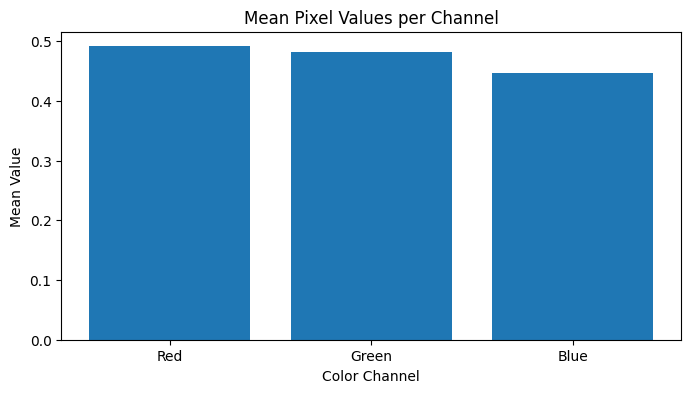

In [10]:
# Analyze image pixel values
# Calculate mean and standard deviation of pixel values for each channel
mean_pixels = np.mean(train_images, axis=(0, 1, 2))
std_pixels = np.std(train_images, axis=(0, 1, 2))

print("Mean Pixel Values:", mean_pixels)
print("Standard Deviation of Pixel Values:", std_pixels)

# Visualize mean pixel values for each channel
plt.figure(figsize=(8, 4))
plt.bar(['Red', 'Green', 'Blue'], mean_pixels)
plt.title('Mean Pixel Values per Channel')
plt.xlabel('Color Channel')
plt.ylabel('Mean Value')
plt.show()

In [11]:
# Convert images to grayscale
def rgb_to_grayscale(images):
    return np.dot(images, [0.299, 0.587, 0.114])

gray_train_images = rgb_to_grayscale(train_images)
gray_test_images = rgb_to_grayscale(test_images)

# Reshape grayscale images to add channel dimension
gray_train_images = gray_train_images[..., np.newaxis]
gray_test_images = gray_test_images[..., np.newaxis]

In [40]:
# Build Generator Model
def build_generator():
    model = models.Sequential()
    model.add(layers.Input(shape=(32, 32, 1)))
    model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(layers.Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(layers.Conv2D(3, (3, 3), padding='same', activation='tanh'))
    return model

In [41]:
# Build Discriminator Model
def build_discriminator():
    model = models.Sequential()
    model.add(layers.Input(shape=(32, 32, 3)))
    model.add(layers.Conv2D(64, (3, 3), strides=(2, 2), padding='same', activation='relu'))
    model.add(layers.Conv2D(128, (3, 3), strides=(2, 2), padding='same', activation='relu'))
    model.add(layers.Flatten())
    model.add(layers.Dense(1, activation='sigmoid'))
    return model

In [42]:
# Instantiate models
generator = build_generator()
discriminator = build_discriminator()

In [43]:
# Compile Discriminator
discriminator.compile(optimizer=tf.keras.optimizers.Adam(0.0002, beta_1=0.5),
                      loss='binary_crossentropy',
                      metrics=['accuracy'])

In [44]:
# Build and compile GAN
discriminator.trainable = False
input_layer = layers.Input(shape=(32, 32, 1))
output_layer = discriminator(generator(input_layer))
gan = models.Model(input_layer, output_layer)
gan.compile(optimizer=tf.keras.optimizers.Adam(0.0002, beta_1=0.5), loss='binary_crossentropy')

In [45]:
# Training parameters
epochs = 100
batch_size = 64
half_batch = batch_size // 2

In [58]:
def train_gan(generator, discriminator, gan, gray_images, color_images, epochs, batch_size):
    for epoch in range(epochs):
        # Train discriminator
        idx = np.random.randint(0, gray_images.shape[0], batch_size // 2)
        gray_imgs = gray_images[idx]
        real_imgs = color_images[idx]

        # Generate fake images
        fake_imgs = generator.predict(gray_imgs)

        # Train discriminator on real and fake images
        d_loss_real, d_acc_real = discriminator.train_on_batch(real_imgs, np.ones((batch_size // 2, 1)))
        d_loss_fake, d_acc_fake = discriminator.train_on_batch(fake_imgs, np.zeros((batch_size // 2, 1)))

        # Average the loss and accuracy from real and fake training
        d_loss = 0.5 * (d_loss_real + d_loss_fake)
        d_acc = 0.5 * (d_acc_real + d_acc_fake)


        # Train generator
        g_loss = gan.train_on_batch(gray_imgs, np.ones((batch_size // 2, 1)))

        # Visualize some results every 10 epochs
        if (epoch + 1) % 10 == 0:
            visualize_results(generator, gray_images, color_images)

# Function to visualize results
def visualize_results(generator, gray_images, color_images, num_images=5):
    idx = np.random.randint(0, gray_images.shape[0], num_images)
    gray_imgs = gray_images[idx]
    color_imgs = color_images[idx]
    fake_imgs = generator.predict(gray_imgs)

    plt.figure(figsize=(15, 5))
    for i in range(num_images):
        plt.subplot(3, num_images, i + 1)
        plt.imshow(gray_imgs[i].squeeze(), cmap='gray')
        plt.axis('off')

        plt.subplot(3, num_images, i + 1 + num_images)
        plt.imshow(fake_imgs[i])
        plt.axis('off')

        plt.subplot(3, num_images, i + 1 + 2 * num_images)
        plt.imshow(color_imgs[i])
        plt.axis('off')
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step


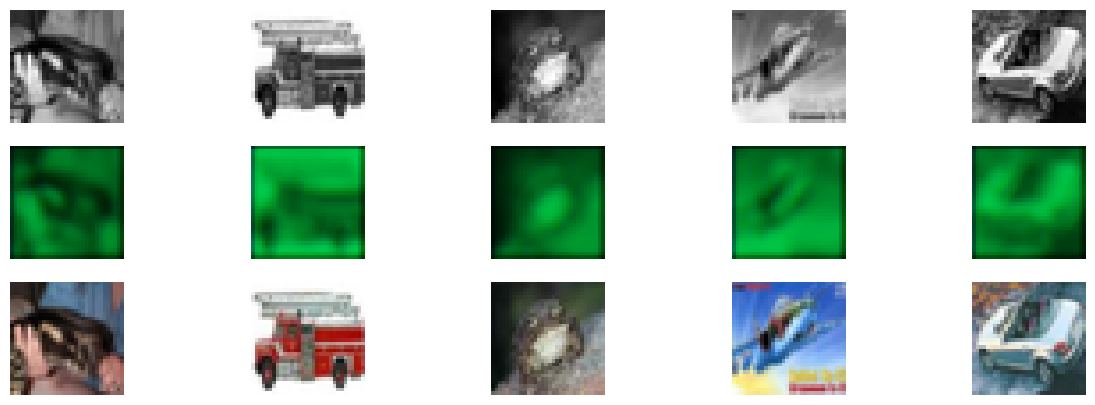

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


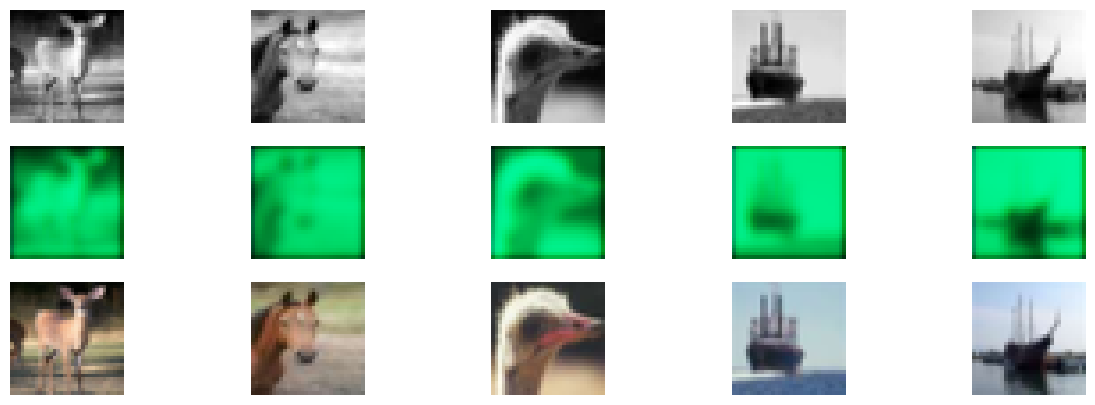

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


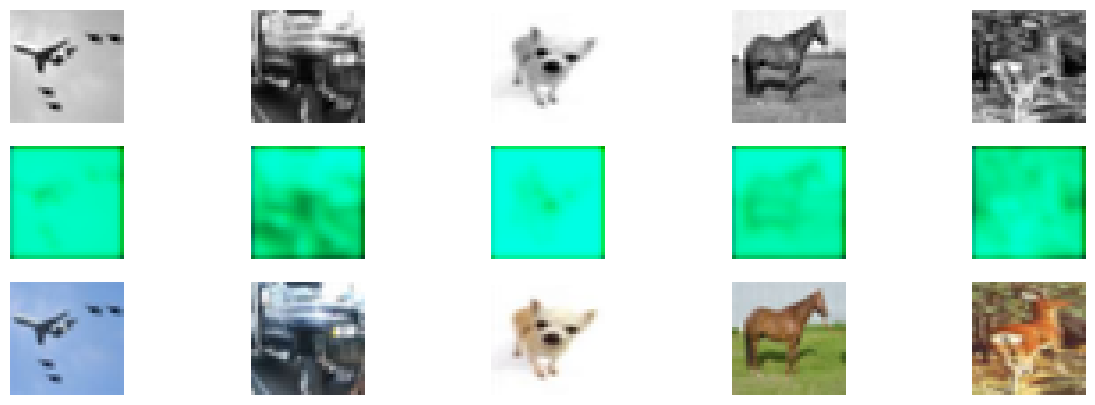

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


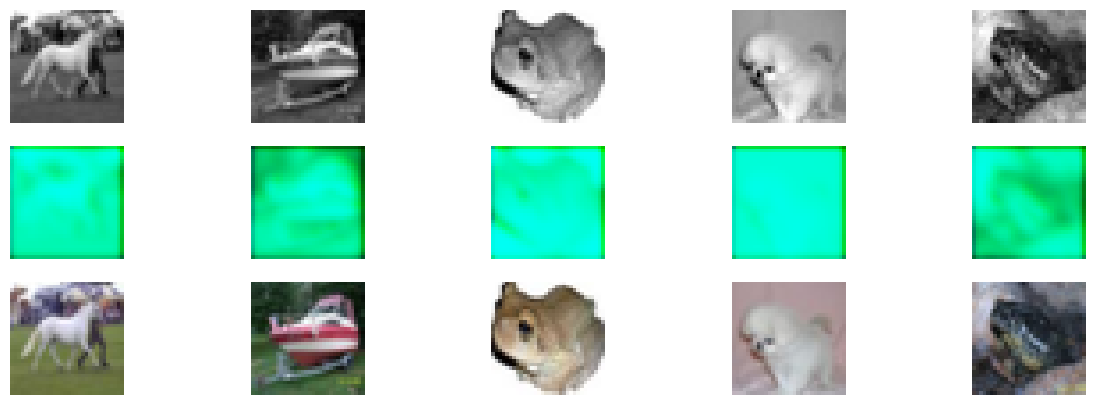

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


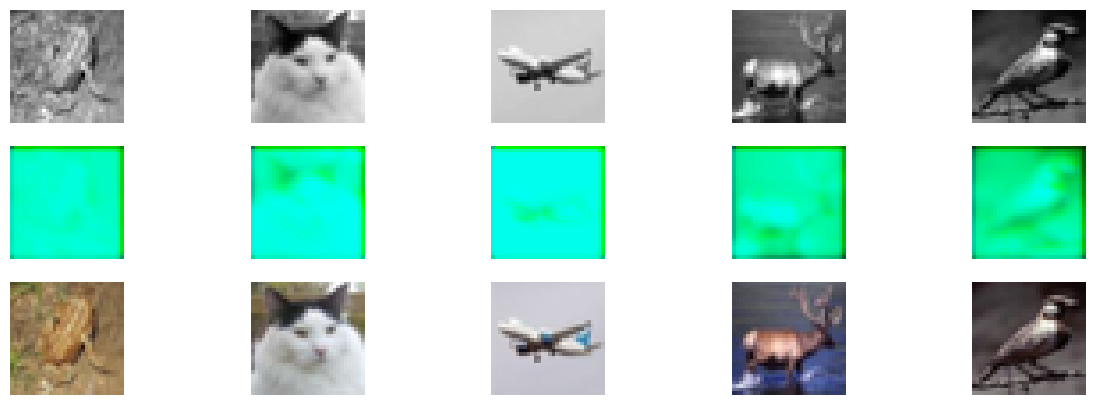

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


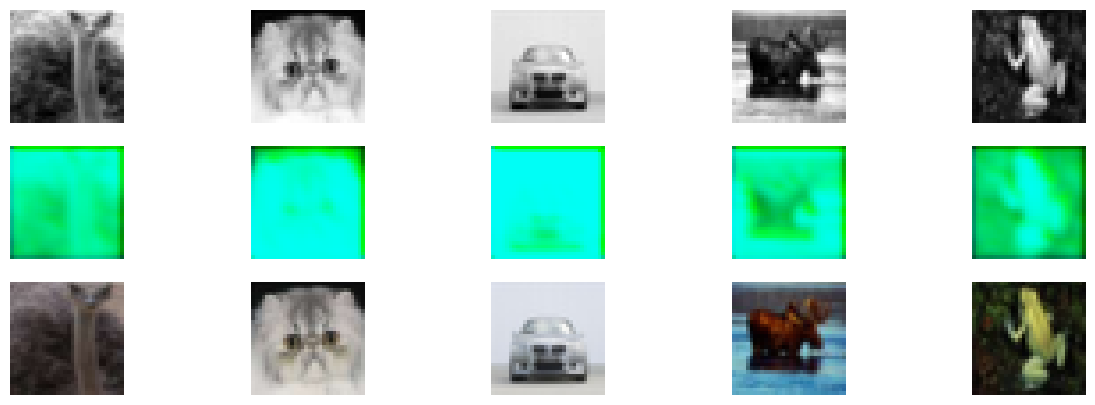

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


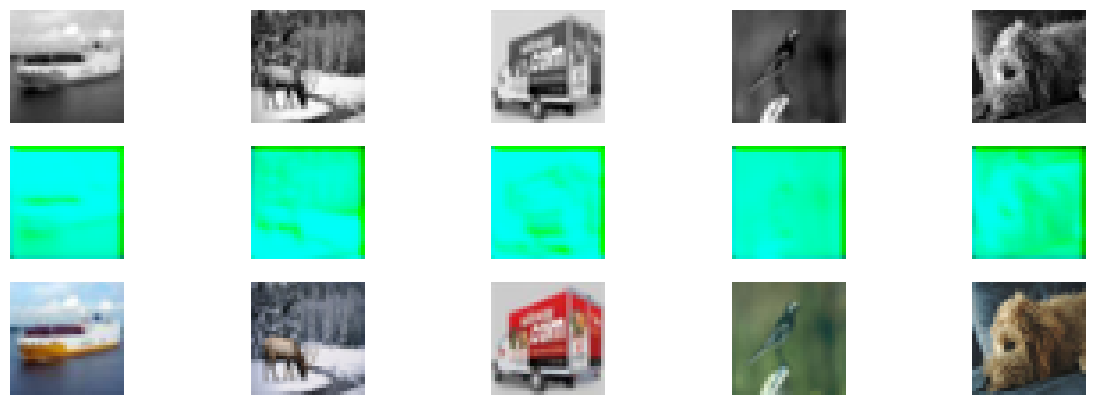

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


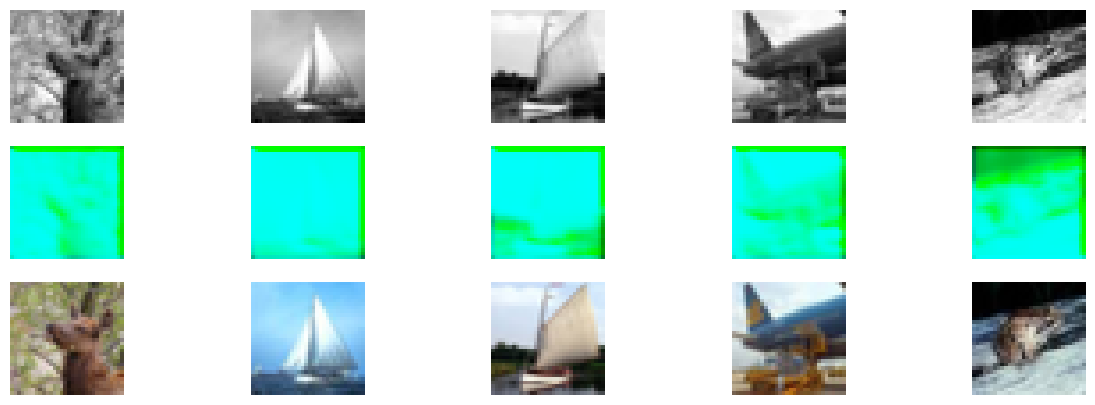

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


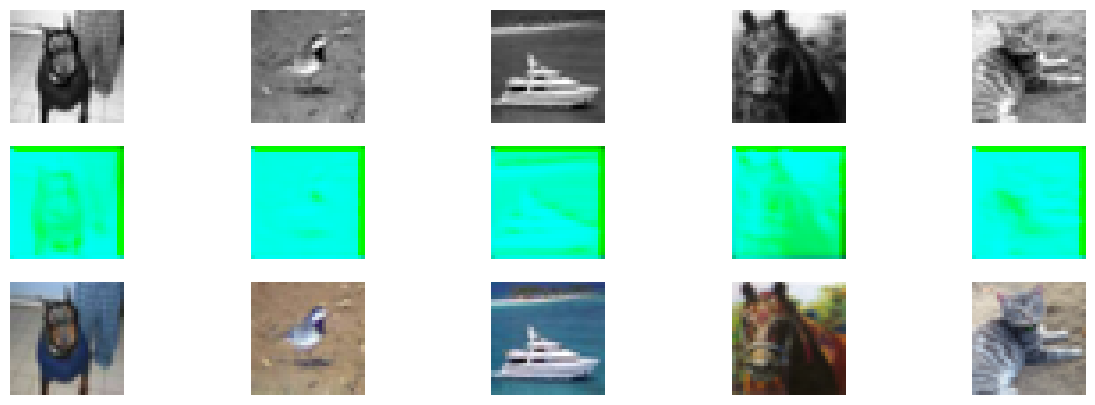

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


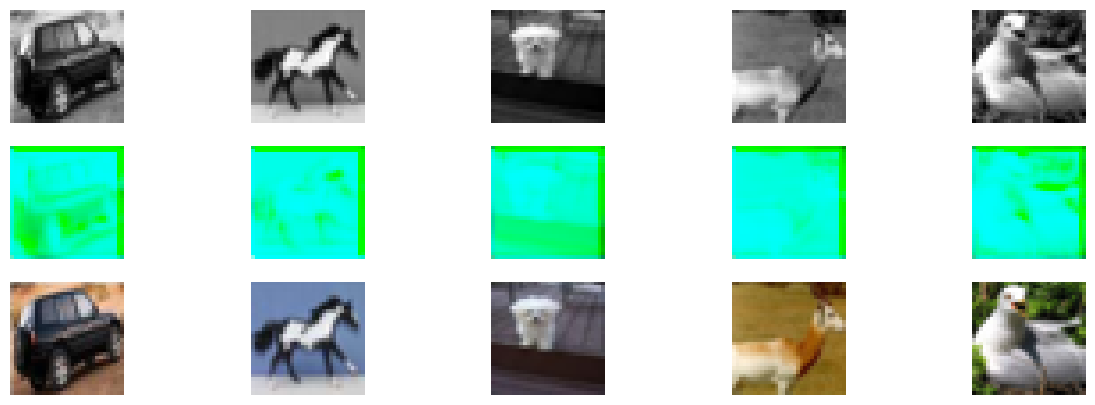

In [59]:
# Start training
train_gan(generator, discriminator, gan, gray_train_images, train_images, epochs, batch_size)

* The model output is much better as the images as colorized fairly.